In [3]:
import pandas as pd
import yfinance as yf
import sys
import os

sys.path.append(os.path.abspath("../Scripts"))
sys.path.append(os.path.abspath("../src"))

from Download_data import StockData
from data_preprocessing import DataPreprocessor
from eda import StockAnalysis

## Task 1: Preprocess and Explore the Data
### Load and Clean Data

In [4]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = "2015-07-01"
end_date = "2025-07-31"

# Create instance of StockData
stock_data = StockData(tickers, start_date, end_date)


In [5]:
df = stock_data.download_data()

c:\Users\Specter\Documents\Tenx_Academy\Week-11\Time-Series-Forecasting-Portfolio-Optimization\src\Download_data.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.data = yf.download(self.tickers, start=self.start_date, end=self.end_date)
[*********************100%***********************]  3 of 3 completed


In [6]:
df.head()

Price           Close                              High              \
Ticker            BND         SPY       TSLA        BND         SPY   
Date                                                                  
2015-07-01  60.816769  174.917145  17.943333  60.914494  175.363920   
2015-07-02  60.967113  174.756943  18.667999  61.027255  175.566203   
2015-07-06  61.177544  174.259583  18.648001  61.222653  175.043542   
2015-07-07  61.237705  175.355453  17.858667  61.470746  175.481894   
2015-07-08  61.410614  172.413452  16.997334  61.463236  174.293280   

Price                        Low                              Open  \
Ticker           TSLA        BND         SPY       TSLA        BND   
Date                                                                 
2015-07-01  18.174667  60.764146  174.124747  17.856667  60.794217   
2015-07-02  18.830000  60.937043  174.335456  18.220667  60.937043   
2015-07-06  18.779333  61.057266  173.256441  18.420000  61.222653   
2015-07-07  18.346666  61.237705  172.059422  17.384666  61.410611   
2015-07-08  17.386667  61.312883  172.177420  16.954000  61.373024   

Price                               Volume                        
Ticker             SPY       TSLA      BND        SPY       TSLA  
Date                                                              
2015-07-01  175.111025  18.073999  5399300  135979900   31518000  
2015-07-02  175.397611  18.680000  1060100  104373700  107458500  
2015-07-06  173.458760  18.591999  2210700  117975400   61828500  
2015-07-07  174.461903  18.333332  4183200  173820200   91576500  
2015-07-08  174.006672  17.288000  1967800  164020100   93316500

In [7]:
# Extract different price categories into separate DataFrames.
close_df, high_df, low_df, open_df, volume_df = stock_data.extract_price_categories()

In [8]:
# Reset index of DataFrames.
close_df, high_df, low_df, open_df, volume_df = stock_data.reset_indexes()

In [9]:
close_df, high_df, low_df, open_df, volume_df = stock_data.melt_data()

In [10]:
# Get the merged DataFrame
stock_data.merge_data()
df_merged = stock_data.get_merged_data()

In [11]:
df_merged.head()

,Date,Ticker,Open,Low,Volume,High,Close
0,2015-07-01,TSLA,18.073999,17.856667,31518000,18.174667,17.943333
1,2015-07-02,TSLA,18.680000,18.220667,107458500,18.830000,18.667999
2,2015-07-06,TSLA,18.591999,18.420000,61828500,18.779333,18.648001
3,2015-07-07,TSLA,18.333332,17.384666,91576500,18.346666,17.858667
4,2015-07-08,TSLA,17.288000,16.954000,93316500,17.386667,16.997334


###  Data cleaning and Understanding

In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7605 entries, 0 to 7604
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7605 non-null   datetime64[ns]
 1   Ticker  7605 non-null   object        
 2   Open    7605 non-null   float64       
 3   Low     7605 non-null   float64       
 4   Volume  7605 non-null   int64         
 5   High    7605 non-null   float64       
 6   Close   7605 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 416.0+ KB


In [13]:
# Summary statistics
df_merged.describe()

,Date,Open,Low,Volume,High,Close
count,7605,7605.000000,7605.000000,7.605000e+03,7605.000000,7605.000000
mean,2020-07-12 16:49:59.289940992,178.199177,176.439129,6.788282e+07,179.837741,178.208641
min,2015-07-01 00:00:00,9.488000,9.403333,0.000000e+00,10.331333,9.578000
25%,2018-01-04 00:00:00,64.726095,64.633130,5.890700e+06,64.791261,64.718109
50%,2020-07-14 00:00:00,94.400665,91.734001,6.240820e+07,97.666664,94.571335
75%,2023-01-19 00:00:00,264.350006,261.211560,9.666270e+07,267.309998,264.350006
max,2025-07-30 00:00:00,638.349976,635.539978,9.140820e+08,638.669983,637.099976
std,NaN,151.799505,150.457746,6.784301e+07,153.033414,151.805674


In [11]:
# Count missing values per column
df_merged.isnull().sum()

Date      0
Ticker    0
Open      0
Low       0
Volume    0
High      0
Close     0
dtype: int64

In [14]:
df_merged.dtypes

Date      datetime64[ns]
Ticker            object
Open             float64
Low              float64
Volume             int64
High             float64
Close            float64
dtype: object

In [19]:
df_merged.Ticker.value_counts()

Ticker
TSLA    2535
BND     2535
SPY     2535
Name: count, dtype: int64

### Handling Duplicates

In [15]:
# Initialize the preprocessor
preprocessor = DataPreprocessor(df_merged)

In [16]:
# Apply data cleaning and transformation steps
preprocessor.handle_duplicates()

Removed 0 duplicate rows.


### Check Outlier

In [24]:
preprocessor.check_outliers()

Outlier count per column: {'Open': np.int64(175), 'Low': np.int64(184), 'Volume': np.int64(208), 'High': np.int64(157), 'Close': np.int64(170)}


### Data Normalization

In [17]:
# Processed Data
processed_data = preprocessor.Normalized_data()
processed_data.head()

,Open,Low,Volume,High,Close,Ticker_SPY,Ticker_TSLA,Date
0,0.013653,0.013501,0.034480,0.012483,0.013331,0.0,1.0,2015-07-01
1,0.014617,0.014082,0.117559,0.013526,0.014486,0.0,1.0,2015-07-02
2,0.014477,0.014400,0.067640,0.013445,0.014454,0.0,1.0,2015-07-06
3,0.014066,0.012747,0.100184,0.012756,0.013196,0.0,1.0,2015-07-07
4,0.012403,0.012059,0.102088,0.011229,0.011823,0.0,1.0,2015-07-08


### Conduct Exploratory Data Analysis (EDA):

In [18]:
# Sort index to ensure chronological order
df = processed_data

In [19]:
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df = df.set_index('Date')

# Sort by the new index
df = df.sort_index()

In [20]:
df.head()

,Open,Low,Volume,High,Close,Ticker_SPY,Ticker_TSLA
Date,,,,,,,
2015-07-01,0.013653,0.013501,0.034480,0.012483,0.013331,0.0,1.0
2015-07-01,0.263369,0.263076,0.148761,0.262649,0.263479,1.0,0.0
2015-07-01,0.081586,0.082028,0.005907,0.080503,0.081653,0.0,0.0
2015-07-02,0.014617,0.014082,0.117559,0.013526,0.014486,0.0,1.0
2015-07-02,0.263825,0.263412,0.114184,0.262971,0.263224,1.0,0.0


In [21]:
# Initialize the analysis class
ts_analysis = StockAnalysis(df)

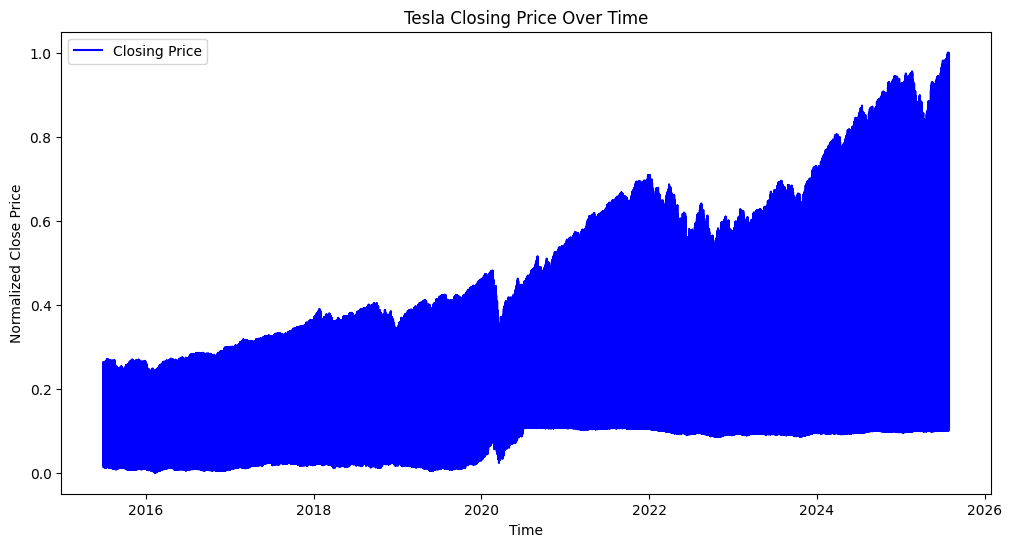

In [22]:
# Run Exploratory Data Analysis
ts_analysis.plot_closing_price()